#**RGB-> 0.5**

#**XYZ-> 0.5** 

In [ ]:
!pip install -q tensorflow-io
import os
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow import keras
from tensorflow.keras.layers import  Lambda, Input, Dense, \
                         Dropout, Flatten,  GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import tensorflow_hub as hub

from utils import DatasetBuilder ,EvaluateModel ,ModelUtils

In [ ]:
DATASET_PATH = os.path.join(os.getcwd(),'drive',"MyDrive", 'Car-Color-Recognition','CarDS')
BATCH_SIZE = 32
IMAGE_SIZE = (300 ,300)
colorspace = "RGB_XYZ"
model_name = "RGB_XYZ"
dsBuilder = DatasetBuilder(DATASET_PATH ,image_size = IMAGE_SIZE ,batch_size = BATCH_SIZE)
train_ds , val_ds = dsBuilder.create('train') , dsBuilder.create('val')
class_names=train_ds.class_names
NUM_CLASSES = len(class_names)

class_weights = dsBuilder.get_class_weights(train_ds)

for key ,value in class_weights.items() : print("{} : {}".format(class_names[key], value.round(3)))

Found 19171 files belonging to 16 classes.
Found 3491 files belonging to 16 classes.
beige : 1.161
black : 0.97
blue : 1.087
brown : 1.14
cream : 2.014
crimson : 1.945
gold : 2.147
green : 1.325
grey : 0.873
navy-blue : 2.031
orange : 1.39
red : 1.152
silver : 1.268
titanium : 1.997
white : 0.209
yellow : 1.297


## **Rate = 0.5**

In [ ]:
rate = 0.5
def combine_rgb_xyz(rgb_image):
  xyz_image = DatasetBuilder.rgb2xyz(rgb_image)
  return (rgb_image*rate)+(xyz_image*(1-rate))

In [ ]:
train_ds = (
    train_ds.
    map(lambda img, lbl: (img/255., lbl), num_parallel_calls=tf.data.AUTOTUNE).
    map(lambda img ,lbl : (combine_rgb_xyz(img) ,lbl) ,num_parallel_calls=tf.data.AUTOTUNE).
    prefetch(tf.data.AUTOTUNE))

val_ds = (
    val_ds.
    map(lambda img, lbl: (img/255., lbl), num_parallel_calls=tf.data.AUTOTUNE).
    map(lambda img ,lbl : (combine_rgb_xyz(img) ,lbl) ,num_parallel_calls=tf.data.AUTOTUNE).
    prefetch(tf.data.AUTOTUNE))

In [ ]:
augmentation = Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomZoom(0.05),
    ]
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

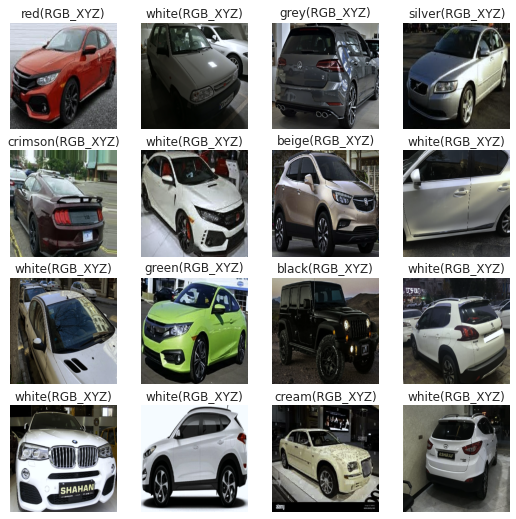

In [ ]:
fig=plt.figure(figsize=(9, 9))
for images, labels in train_ds.take(1):
    for i in range(16):
      plt.subplot(4, 4, i + 1)
      image = tf.expand_dims(images[i] ,axis=0)
      lbl = "{}({})".format(class_names[labels[i].numpy().argmax()] , colorspace )
      plt.imshow(tf.squeeze(image))
      plt.title(lbl)
      plt.axis("off")
    break

In [ ]:
do_fine_tuning = True

url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2"
base_model = hub.KerasLayer(url,trainable=do_fine_tuning)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    augmentation,
    base_model,
    Dense(400),
    Dropout(0.3),
    tf.keras.layers.Dense(NUM_CLASSES,activation = "softmax", kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1536)              12930622  
                                                                 
 dense (Dense)               (None, 400)               614800    
                                                                 
 dropout (Dropout)           (None, 400)               0         
                                                                 
 dense_1 (Dense)             (None, 16)                6416      
                                                                 
Total params: 13,551,838
Trainable params: 13,442,622
Non-trainable params: 109,216
_________________________________________________________________


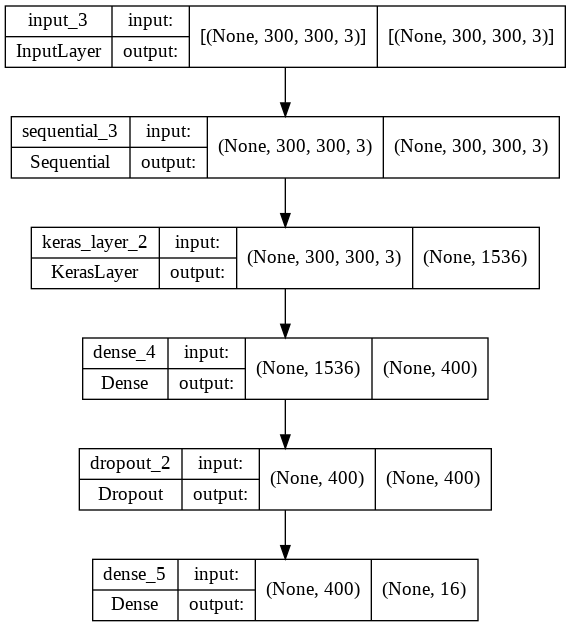

In [ ]:
tf.keras.utils.plot_model(model, to_file='model_RGB_XYZ.png', show_shapes=True)

# **Train_1**

In [ ]:
model_utils = ModelUtils(model_name ,"HUB")
run_index = 1
callbacks= model_utils.get_callbacks(run_index = run_index )
model = model_utils.make_or_restore_model(model,"SGD",lr = 1e-2)
n_epochs = 50
print("{}: ".format(model_name))
model.fit(train_ds,
          validation_data=val_ds,
          epochs=n_epochs,
          callbacks=callbacks,
          class_weight = class_weights
          )   

Creating a new model
RGB_XYZ: 
Epoch 1/50
600/600 [==============================] - ETA: 0s - loss: 0.8821 - accuracy: 0.7279
Epoch 1: val_loss improved from inf to 0.74565, saving model to /content/drive/MyDrive/Car-Color-Recognition/Callbacks/Checkpoints/RGB_XYZ/_1.h5
600/600 [==============================] - 4172s 7s/step - loss: 0.8821 - accuracy: 0.7279 - val_loss: 0.7457 - val_accuracy: 0.7548 - lr: 0.0100
Epoch 2/50
600/600 [==============================] - ETA: 0s - loss: 0.4926 - accuracy: 0.8440
Epoch 2: val_loss improved from 0.74565 to 0.63772, saving model to /content/drive/MyDrive/Car-Color-Recognition/Callbacks/Checkpoints/RGB_XYZ/_2.h5
600/600 [==============================] - 395s 655ms/step - loss: 0.4926 - accuracy: 0.8440 - val_loss: 0.6377 - val_accuracy: 0.8112 - lr: 0.0100
Epoch 3/50
600/600 [==============================] - ETA: 0s - loss: 0.3724 - accuracy: 0.8784
Epoch 3: val_loss improved from 0.63772 to 0.58836, saving model to /content/drive/MyDrive/Ca

In [ ]:
model_utils.save_model_and_history(model ,run_index)

In [ ]:
model_utils = ModelUtils(model_name ,"HUB")
model = model_utils.make_or_restore_model(model)

Restoring from /content/drive/MyDrive/Car-Color-Recognition/Callbacks/Checkpoints/RGB_XYZ/_8.h5


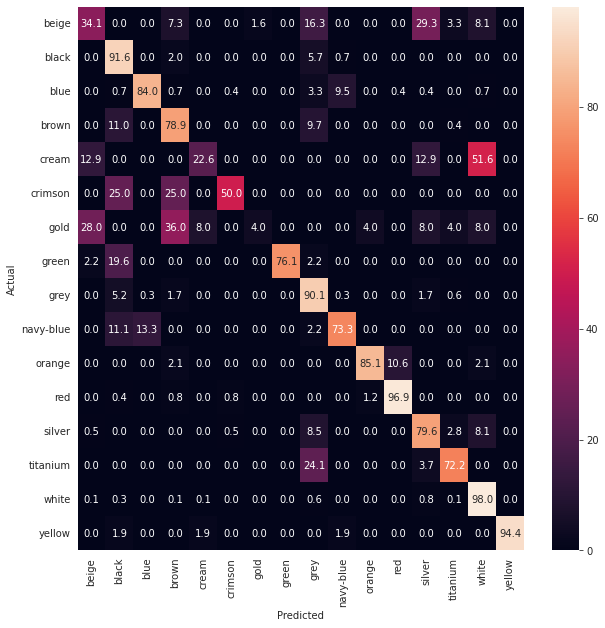

In [ ]:
eval = EvaluateModel(model ,val_ds ,class_names,"RGB_XYZ")
eval.plot_confusion()

In [ ]:
eval.report()

Report CSV file added to logs .


,precision,recall,f1-score,support
beige,0.750000,0.341463,0.469274,123.000000
black,0.800587,0.916107,0.854460,298.000000
blue,0.970588,0.840000,0.900585,275.000000
brown,0.831111,0.789030,0.809524,237.000000
cream,0.636364,0.225806,0.333333,31.000000
crimson,0.500000,0.500000,0.500000,8.000000
gold,0.333333,0.040000,0.071429,25.000000
green,1.000000,0.760870,0.864198,46.000000
grey,0.735714,0.900875,0.809961,343.000000
navy-blue,0.523810,0.733333,0.611111,45.000000
